<a href="https://colab.research.google.com/github/MalakhovDenis/DLS-DL2/blob/main/11.%20%D0%94%D0%97.%20%D0%9F%D1%80%D0%B5%D0%B4%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5%20%D0%B8%20%D0%B4%D0%BE%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5%20%D1%8F%D0%B7%D1%8B%D0%BA%D0%BE%D0%B2%D1%8B%D1%85%20%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9/11.1%20%D0%A2%D1%80%D0%B0%D0%BD%D1%81%D1%84%D0%BE%D1%80%D0%BC%D0%B5%D1%80%D1%8B/Malakhov%5Bhomework4%5DAttention_and_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

### ⚙️ Импорт библиотек и предобработка данных

In [1]:
!pip install tensorboard evaluate transformers datasets pymorphy2 -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 600.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu1

In [2]:
!pip install --upgrade pymorphy2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Импортируем необходимые библиотеки для дальнейшего анализа

import gdown

import os
import gc
import random
import copy
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import nltk
import pymorphy2
nltk.download('stopwords')
from nltk.corpus import stopwords

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import evaluate

import transformers
from transformers import BertTokenizer, BertModel, get_scheduler

sns.set(palette='summer')

print('Все библиотеки импортированы')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Все библиотеки импортированы


In [5]:
!gdown 13YIbphbWc62sfa-bCh8MLQWKizaXbQK9

Downloading...
From: https://drive.google.com/uc?id=13YIbphbWc62sfa-bCh8MLQWKizaXbQK9
To: /content/data_problems_translated.xlsx
100% 526k/526k [00:00<00:00, 103MB/s]


In [6]:
!nvidia-smi
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

Sun Apr  6 16:04:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

'cuda'

In [7]:
SEED = 42

def seed_torch(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

seed_torch(SEED)

In [8]:
# Загрузим данные, посмотрим на их структуру

data = pd.read_excel('./data_problems_translated.xlsx', index_col=0)
print(data.shape)
data.head()

(5273, 2)


,problem_text,topic
0,To prove that the sum of the numbers of the ex...,number_theory
1,( b) Will the statement of the previous challe...,number_theory
2,The quadratic three-member graph with the coef...,polynoms
3,Can you draw on the surface of Rubik's cube a ...,combinatorics
4,"Dima, who came from Vrunlandia, said that ther...",graphs


In [9]:
data.columns = ['text','label']

In [10]:
print(f'Количество уникальных лейблов: {data.label.nunique()}')
data.label.value_counts()

Количество уникальных лейблов: 7


,count
label,
number_theory,2396
combinatorics,1020
dirichlet,441
polynoms,426
graphs,384
geometry,371
invariant,235


,len_text
count,5273.000000
mean,229.931538
std,215.601297
min,0.000000
25%,105.000000
50%,179.000000
75%,286.000000
max,2506.000000


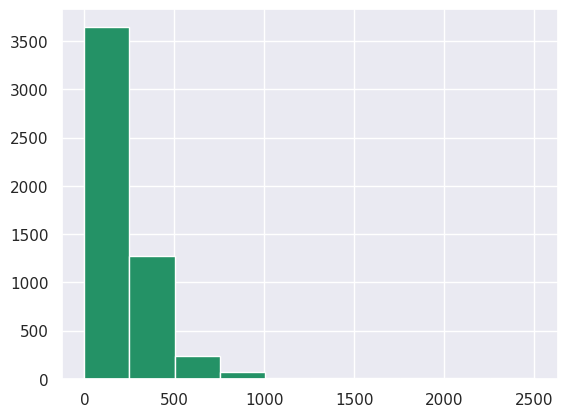

In [11]:
data['text'] = data['text'].fillna('').astype(str)
data['len_text'] = data.text.apply(lambda x: len(str(x)))
display(data.describe())
data.len_text.hist()
None

In [12]:
# Проверка на дубликаты в данных

data.shape, data.drop_duplicates().shape, data.drop_duplicates('text').shape

((5273, 3), (5244, 3), (4319, 3))

In [13]:
data.groupby('text').label.nunique().sort_values(ascending=False).reset_index().head()

,text,label
0,"It's okay. It's okay, it's okay, it's okay.",7
1,Each of the 102 pupils in one school is famili...,4
2,( a) Could it happen that in a company of 10 g...,4
3,How can n > 1 happen in a company of n + 1 gir...,4
4,"On the big chess board, 2n cells were marked s...",4


In [14]:
data.dtypes, data.isna().sum()

(text        object
 label       object
 len_text     int64
 dtype: object,
 text        0
 label       0
 len_text    0
 dtype: int64)

In [15]:
data[data.text.str.contains("It's okay. It's okay")].drop_duplicates(['text','label'])

,text,label,len_text
548,"It's okay. It's okay, it's okay, it's okay.",graphs,43
968,"It's okay. It's okay, it's okay, it's okay.",dirichlet,43
1665,"It's okay. It's okay, it's okay, it's okay.",geometry,43
1995,"It's okay. It's okay, it's okay, it's okay.",combinatorics,43
2211,"It's okay. It's okay, it's okay, it's okay.",number_theory,43
2281,"It's okay. It's okay, it's okay, it's okay.",polynoms,43
3668,"It's okay. It's okay, it's okay, it's okay.",invariant,43


Вывод:
* В данных есть дубликаты по задачам, однако каждый из них имеет несколько Тем! Таким образом решение задачи может быть либо задача Multilabel, либо при вычистке дубликатов можно решать задачу Multiclass.
* Длина предложения самого текста задачи от 0 до 2506 симовлов, при 50 и 75 квантиле 179 и 286 соответственно. Таким образом падить будет не очень хорошей идеей, надо фильтрануть наблюдения по длине предложения

---
1) Удалим Дубликаты по конверсии лейблов

In [16]:
# Заведем ранжировку для каждого из лейблов и возьмем тот, где первого, где меньше количество наблюдений

rang_dict = {k:v for v,k in enumerate(data.label.value_counts().sort_values().index)}
data['rang_label'] = data.label.map(rang_dict)

In [17]:
(data.sort_values(['text','rang_label']).drop_duplicates('text',keep='first').drop(columns='rang_label').label.value_counts()
,data.sort_values(['text','rang_label']).drop_duplicates('text',keep='last').drop(columns='rang_label').label.value_counts())

(label
 number_theory    1964
 combinatorics     577
 polynoms          407
 dirichlet         390
 graphs            379
 geometry          367
 invariant         235
 Name: count, dtype: int64,
 label
 number_theory    2391
 combinatorics     811
 geometry          363
 polynoms          357
 dirichlet         268
 invariant         117
 graphs             12
 Name: count, dtype: int64)

In [18]:
# Заведем ранжировку для каждого из лейблов и возьмем тот, где первого, где меньше количество наблюдений

rang_dict = {k:v for v,k in enumerate(data.label.value_counts().sort_values().index)}
data['rang_label'] = data.label.map(rang_dict)
data = data.sort_values(['text','rang_label']).drop_duplicates('text',keep='first').drop(columns='rang_label')

In [19]:
from sklearn.model_selection import train_test_split

label_to_ind = {label:ind for ind,label in enumerate(data.label.unique())}
int_to_label = {ind: label for label, ind in label_to_ind.items()}
NUM_CLASSES = len(label_to_ind)

data['label'] = data['label'].map(label_to_ind)

train_data, eval_data = train_test_split(data[['text','label']], stratify=data['label'], test_size=0.15, random_state=SEED, shuffle=True)

---
2) Посмотрим на выбросы по длинам предложений

In [20]:
# Part of code is from Seminar Attention and Transformers

ENG_STOP_WORDS = set(stopwords.words('english'))
PUNCT_WORD_TOKENIZER = nltk.WordPunctTokenizer() # for preprocess
# for broadening your horizons use it for lemmatization
MORPH_ANALYZER = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    nums_filtered_text = re.sub(r'[0-9]+', '', text.lower())
    punct_filtered_text = ''.join(
        [ch for ch in nums_filtered_text if ch not in string.punctuation]
    )
    tokens = PUNCT_WORD_TOKENIZER.tokenize(punct_filtered_text)
    filtr_stop_words_tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in tokens
                             if token not in ENG_STOP_WORDS]
    norm_tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in filtr_stop_words_tokens]

    return f"[CLS] {' '.join(norm_tokens)}"

AttributeError: module 'inspect' has no attribute 'getargspec'

In [ ]:
# Слелаем расчет на Интерквартильный размах и посчитаем выбросы по длине предложений

from scipy.stats import iqr

data = data[data.len_text>=data.len_text.quantile(0.01)]

print(data.len_text.quantile(0.25)-iqr(data.len_text),
      data.len_text.quantile(0.25),
      data.len_text.quantile(0.5),
      data.len_text.quantile(0.75),
      data.len_text.quantile(0.75)+iqr(data.len_text))

In [ ]:
# Part of code is from Seminar Attention and Transformers
## Changed hug_dataset to my_dataset

MAX_LENGTH = int(data.len_text.quantile(0.75))

class MyDataset(Dataset):
  def __init__(self,
               my_dataset,
               tokenizer,
               device=DEVICE):

    self.text = my_dataset['text'].apply(lambda x: preprocess_text(x)).tolist()
    self.target = my_dataset['label'].tolist()
    self.tokenizer = tokenizer
    self.device = device

  def __getitem__(self, idx):
    prep_text = self.text[idx]
    target = self.target[idx]

    tokenized_text = self.tokenizer(text=prep_text,
                                    padding="max_length",
                                    max_length=MAX_LENGTH,
                                    truncation=True,
                                    return_tensors='pt')

    text_ids = tokenized_text['input_ids'].flatten()
    attention_mask = tokenized_text['attention_mask'].flatten()

    return text_ids, attention_mask, torch.tensor(target, dtype=torch.long)

  def __len__(self):
    return len(self.text)

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [ ]:
### This is just an interface example. You may change it if you want.

class TransformerClassificationModel(nn.Module):
    def __init__(base_transformer_model: Union[str, nn.Module]):
        self.backbone = #...
        # YOUR CODE: create additional layers for classfication

    def forward(inputs, ...):
        # YOUR CODE: propagate inputs through the model. Return dict with logits

        outputs = {<YOUR CODE>}
        return # YOUR CODE

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [ ]:
def freeze_backbone_function(model: TransformerClassificationModel):
    pass

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [ ]:
import copy

def train_transformer(transformer_model, freeze_backbone=True)
    model = copy.copy(transformer_model)
    ### YOUR CODE IS HERE

    return finetuned_model

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [ ]:
rubert_tiny_transformer_model = #...
rubert_tiny_finetuned_with_freezed_backbone = train_transformer(rubert_tiny_transformer_model, freeze_backbone=True)

rubert_tiny_transformer_model = #...
rubert_tiny_full_finetuned = train_transformer(rubert_tiny_transformer_model, freeze_backbone=False)

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [ ]:
### YOUR CODE IS HERE (probably, similar on the previous step)

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [ ]:
def draw_first_layer_attention_maps(attention_head_ids: List, text: str, model: TransformerClassificationModel):
    pass

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

In [ ]:
### YOUR CODE IS HERE

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

In [ ]:
### YOUR CODE IS HERE